In [1]:
pip install transformers torch pandas numpy scikit-learn tqdm tensorflow

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import numpy as np
import torch
from torch import nn
from transformers import RobertaTokenizer, RobertaModel, AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

In [3]:
# Importing data from google drive
video_data = pd.read_csv('Advertisement_videos_dataset.csv')
video_data.head(10)

,Unnamed: 0,Video Id,Title,Description,Category
0,0,ehmsJLZlCZ0,Ep 1| Travelling through North East India | Of...,"The journey to Arunachal, North East India beg...",travel
1,1,e2NQE41J5eM,How do I travel so much ! How do I earn money!!,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...,travel
2,2,i9E_Blai8vk,TRAVEL VLOG ∙ Welcome to Bali | PRISCILLA LEE,I had the chance to fly out to Bali with my wh...,travel
3,3,#NAME?,GOA TRAVEL DIARY | FOUR DAYS IN GOA | TRAVEL O...,Hope you enjoy MY GOA TRAVEL DIARY this video!...,travel
4,4,7ByoBJYXU0k,5 Steps to Becoming a Travel Blogger,"Travel blogger, Nikki Vargas, of The Pin the M...",travel
5,5,yvn79Rv0F48,Backpacking In Meghalaya | NorthEast India Tri...,"In this video I explored North East India, sta...",travel
6,6,SL_YBLWdZb8,Welcome to Peru! | Best Essential Tips &amp; T...,Welcome to Peru! This essential travel guide w...,travel
7,7,kiNyRY5s7n8,How to Start a Travel Blog [2019] Travel Blogg...,Create a Travel Blog Website for Just $3.95 + ...,travel
8,8,kY41XgTEEQU,A Day with KSRTC Bus Fans - Aanavandi Travel B...,ആനവണ്ടി ഭ്രാന്തൻമാരോടൊപ്പം കുമളിയിൽ ഒരു ദിവസം ...,travel
9,9,7mIzRYh8jGA,What is it like to travel in PAKISTAN?,Subscribe now: https://goo.gl/6zXZGK Watch the...,travel


In [4]:
data = video_data.drop(['Unnamed: 0'], axis = 1)
data.head(10)

,Video Id,Title,Description,Category
0,ehmsJLZlCZ0,Ep 1| Travelling through North East India | Of...,"The journey to Arunachal, North East India beg...",travel
1,e2NQE41J5eM,How do I travel so much ! How do I earn money!!,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...,travel
2,i9E_Blai8vk,TRAVEL VLOG ∙ Welcome to Bali | PRISCILLA LEE,I had the chance to fly out to Bali with my wh...,travel
3,#NAME?,GOA TRAVEL DIARY | FOUR DAYS IN GOA | TRAVEL O...,Hope you enjoy MY GOA TRAVEL DIARY this video!...,travel
4,7ByoBJYXU0k,5 Steps to Becoming a Travel Blogger,"Travel blogger, Nikki Vargas, of The Pin the M...",travel
5,yvn79Rv0F48,Backpacking In Meghalaya | NorthEast India Tri...,"In this video I explored North East India, sta...",travel
6,SL_YBLWdZb8,Welcome to Peru! | Best Essential Tips &amp; T...,Welcome to Peru! This essential travel guide w...,travel
7,kiNyRY5s7n8,How to Start a Travel Blog [2019] Travel Blogg...,Create a Travel Blog Website for Just $3.95 + ...,travel
8,kY41XgTEEQU,A Day with KSRTC Bus Fans - Aanavandi Travel B...,ആനവണ്ടി ഭ്രാന്തൻമാരോടൊപ്പം കുമളിയിൽ ഒരു ദിവസം ...,travel
9,7mIzRYh8jGA,What is it like to travel in PAKISTAN?,Subscribe now: https://goo.gl/6zXZGK Watch the...,travel


In [5]:
# Counting the number of nulls in each attribute
data.isnull().sum()

,0
Video Id,0
Title,0
Description,334
Category,0


In [6]:
print(data.shape)
data = data.dropna(how='any')
print(data.shape)

(10333, 4)
(9999, 4)


In [7]:
data

,Video Id,Title,Description,Category
0,ehmsJLZlCZ0,Ep 1| Travelling through North East India | Of...,"The journey to Arunachal, North East India beg...",travel
1,e2NQE41J5eM,How do I travel so much ! How do I earn money!!,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...,travel
2,i9E_Blai8vk,TRAVEL VLOG ∙ Welcome to Bali | PRISCILLA LEE,I had the chance to fly out to Bali with my wh...,travel
3,#NAME?,GOA TRAVEL DIARY | FOUR DAYS IN GOA | TRAVEL O...,Hope you enjoy MY GOA TRAVEL DIARY this video!...,travel
4,7ByoBJYXU0k,5 Steps to Becoming a Travel Blogger,"Travel blogger, Nikki Vargas, of The Pin the M...",travel
...,...,...,...,...
10328,19jiwpTUGsY,Watercolor scenery painting demo - Rainy Day,Watercolor scenery painting demo - Rainy Day O...,art and music
10329,IMqrRwFf_20,Speed painting Blackstone Fortress: Ur-Ghuls,Music by Midwinter Minis. Enjoyed this series?...,art and music
10330,h96QOHz6i68,Fabric painting step by step flowers painting ...,If you loved the video then please like share ...,art and music
10331,HyZfRPZZu5Y,The Upside | &quot;Dell Unveils Painting&quot;...,THE UPSIDE is director Neil Burger's heartfelt...,art and music


In [8]:
import plotly.express as px

# Calculate the value counts
class_counts = data['Category'].value_counts()

# Create an interactive bar plot using plotly
fig = px.bar(x=class_counts.index, y=class_counts.values,
             labels={'x': 'Category', 'y': 'Number of Videos'},
             title='Distribution of Video Categories')

# Customize the layout
fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Number of Videos',
    xaxis_tickangle=-45,
    width=1000,
    height=600
)

# Show the plot
fig.show()

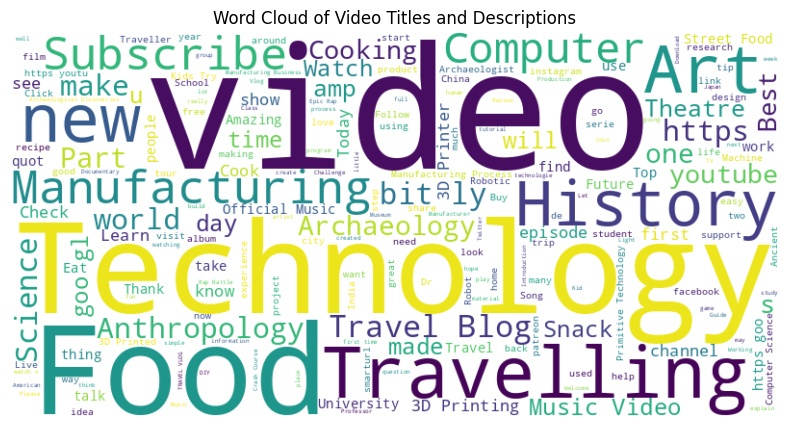

In [9]:
from wordcloud import WordCloud

# Combine all text data
all_text = ' '.join(data['Title'] + ' ' + data['Description'])

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Video Titles and Descriptions')
plt.show()

In [10]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:
stop_words = set(stopwords.words('english'))


# Creating a list of custom stopwords
new_words = ["fig","figure","image","sample","using", "show", "result", "large",
             "also", "one", "two", "three", "four", "five", "seven","eight","nine"]

stop_words = list(stop_words.union(new_words))

In [12]:
def pre_process(text):
  """
    Preprocesses the input text by performing the following operations:
    1. Converts the text to lowercase
    2. Removes HTML tags
    3. Removes special characters and digits
    4. Tokenizes the text into words
    5. Removes stopwords
    6. Removes words with less than three letters
    7. Applies lemmatization to convert words to their base form

    Args:
    text (str): The input text to be preprocessed

    Returns:
    str: The preprocessed text as a single string with words separated by spaces
    """

  # Lowercase conversion
  text=text.lower()

  # Removing tags
  text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

  # Removing special characters and digits
  text=re.sub("(\\d|\\W)+"," ",text)

  # Converting to list from string
  text = text.split()

  # Removing stopwords
  text = [word for word in text if word not in stop_words]

  # Removing words less than three letters
  text = [word for word in text if len(word) >= 3]

  # Lemmatization
  lmtzr = WordNetLemmatizer()
  text = [lmtzr.lemmatize(word, "v") for word in text]

  return ' '.join(text)

In [13]:
# The 'frac' parameter determines the proportion of rows to include in the random sample
# Setting 'drop=True' in .reset_index() prevents the creation of a new column containing the original index values

data = data.sample(frac=1).reset_index(drop=True)
docs = pd.DataFrame()
docs['Title'] = data['Title'].apply(lambda x:pre_process(x))
docs['Description'] = data['Description'].apply(lambda x:pre_process(x))

In [14]:
docs.head()

,Title,Description
0,inside jet engine manufacture amp test wild,subscribe channel http invent eggvzk fly airpl...
1,epic flamin hot cheetos eat challenge hot amp ...,download nostra pro app earn money cricket fes...
2,flexible print filaments test flex best,load flexible print filaments market today dif...
3,india vlog first class train travel full time,ride hour train ride hour layover another hour...
4,looney tune time travel bug kid,everything screw daffy order save everyone bug...


In [15]:
# Label encoding the classes to digits
docs['classes'] = data['Category']
docs['classes'].value_counts()

,count
classes,
food,1695
manufacturing,1673
art and music,1672
travel,1671
science and technology,1656
history,1632


In [16]:
# Encode classes

le = LabelEncoder()
le.fit(docs['classes'])
docs['classes'] = le.transform(docs['classes'])
docs.head()

,Title,Description,classes
0,inside jet engine manufacture amp test wild,subscribe channel http invent eggvzk fly airpl...,3
1,epic flamin hot cheetos eat challenge hot amp ...,download nostra pro app earn money cricket fes...,1
2,flexible print filaments test flex best,load flexible print filaments market today dif...,3
3,india vlog first class train travel full time,ride hour train ride hour layover another hour...,5
4,looney tune time travel bug kid,everything screw daffy order save everyone bug...,5


In [17]:
le.classes_

array(['art and music', 'food', 'history', 'manufacturing',
       'science and technology', 'travel'], dtype=object)

# Here
- art and music -> 0
- food -> 1
- history -> 2
- manufacturing -> 3
- science and technology -> 4
- travel -> 5

In [18]:
docs['classes'].value_counts()

,count
classes,
1,1695
3,1673
0,1672
5,1671
4,1656
2,1632


In [19]:
# Preprocess Data- combine title and description
def preprocess_data_add_combined_text(df):
    # Combine title and description for better context
    df['combined_text'] = df['Title'] + ' ' + df['Description']

    # Clean the text
    df['combined_text'] = df['combined_text'].str.lower()
    df['combined_text'] = df['combined_text'].str.replace('[^\w\s]', '')

    return df

In [20]:
docs = preprocess_data_add_combined_text(docs)

In [21]:
docs.head(10)

,Title,Description,classes,combined_text
0,inside jet engine manufacture amp test wild,subscribe channel http invent eggvzk fly airpl...,3,inside jet engine manufacture amp test wild su...
1,epic flamin hot cheetos eat challenge hot amp ...,download nostra pro app earn money cricket fes...,1,epic flamin hot cheetos eat challenge hot amp ...
2,flexible print filaments test flex best,load flexible print filaments market today dif...,3,flexible print filaments test flex best load f...
3,india vlog first class train travel full time,ride hour train ride hour layover another hour...,5,india vlog first class train travel full time ...
4,looney tune time travel bug kid,everything screw daffy order save everyone bug...,5,looney tune time travel bug kid everything scr...
5,cylce history week,slice missy wilson excellent science overview see,2,cylce history week slice missy wilson excellen...
6,future manufacture,november carnegie mellon university advance ro...,3,future manufacture november carnegie mellon un...
7,japan develop technology hindi quick support,japan develop technology hindi quick support आपक,4,japan develop technology hindi quick support j...
8,snack crate eat israeli snack,month snack crate yes post october june extrem...,1,snack crate eat israeli snack month snack crat...
9,student amazon open doors technology,tecnologia transforma escolas todos cantos mun...,4,student amazon open doors technology tecnologi...


# **MODEL 1: SEQUENTIAL LSTM**

In [22]:
# Vectorizing text features using TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_title = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
tfidf_desc = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
labels = docs['classes']
features_title = tfidf_title.fit_transform(docs['Title']).toarray()
features_description = tfidf_desc.fit_transform(docs['Description']).toarray()
print('Title Features Shape: ' + str(features_title.shape))
print('Description Features Shape: ' + str(features_description.shape))

Title Features Shape: (9999, 2622)
Description Features Shape: (9999, 5162)


In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 100

# Combining titles and descriptions into a single sentence
titles = docs['Title'].values
descriptions = docs['Description'].values
data_for_lstms = []
for i in range(len(titles)):
    temp_list = [titles[i], descriptions[i]]
    data_for_lstms.append(' '.join(temp_list))

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_for_lstms)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Convert the data to padded sequences
X = tokenizer.texts_to_sequences(data_for_lstms)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

# One-hot Encode labels
Y = pd.get_dummies(docs['classes']).values
print('Shape of label tensor:', Y.shape)

# Splitting into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 42)

Found 24085 unique tokens.
Shape of data tensor: (9999, 50)
Shape of label tensor: (9999, 6)


In [24]:
titles[0:4]

array(['inside jet engine manufacture amp test wild',
       'epic flamin hot cheetos eat challenge hot amp spicy cheetos eat competition food challenge',
       'flexible print filaments test flex best',
       'india vlog first class train travel full time'], dtype=object)

In [25]:
data_for_lstms[0:4]

['inside jet engine manufacture amp test wild subscribe channel http invent eggvzk fly airplane often think jet engines aviation facility peebles',
 'epic flamin hot cheetos eat challenge hot amp spicy cheetos eat competition food challenge download nostra pro app earn money cricket festival sport knowledge app link https nstra pro lsbv sign bonus',
 'flexible print filaments test flex best load flexible print filaments market today different properties feature video put different brand test',
 'india vlog first class train travel full time ride hour train ride hour layover another hour ride total hours train train station wow get jaisalmer']

In [31]:
# Define LSTM Model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_shape=(56,), input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 56, 100)             │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 56, 100)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081,006 (4.12 MB)

 Trainable params: 1,081,006 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
# Training LSTM Model
epochs = 5
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.3040 - loss: 1.7082 - val_accuracy: 0.8147 - val_loss: 0.8067
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.8489 - loss: 0.5720 - val_accuracy: 0.9767 - val_loss: 0.1159
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9773 - loss: 0.1115 - val_accuracy: 0.9853 - val_loss: 0.0822
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9866 - loss: 0.0733 - val_accuracy: 0.9860 - val_loss: 0.0723
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9925 - loss: 0.0408 - val_accuracy: 0.9853 - val_loss: 0.0695


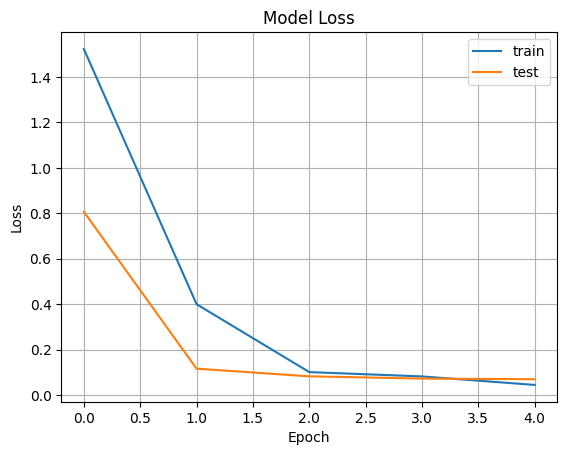

In [33]:
plt.title('Model Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

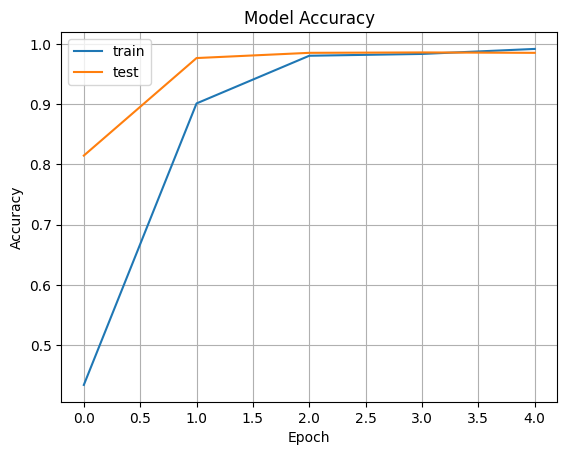

In [34]:
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# For numerical test accuracy
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9861 - loss: 0.0738
Test accuracy: 0.9856


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


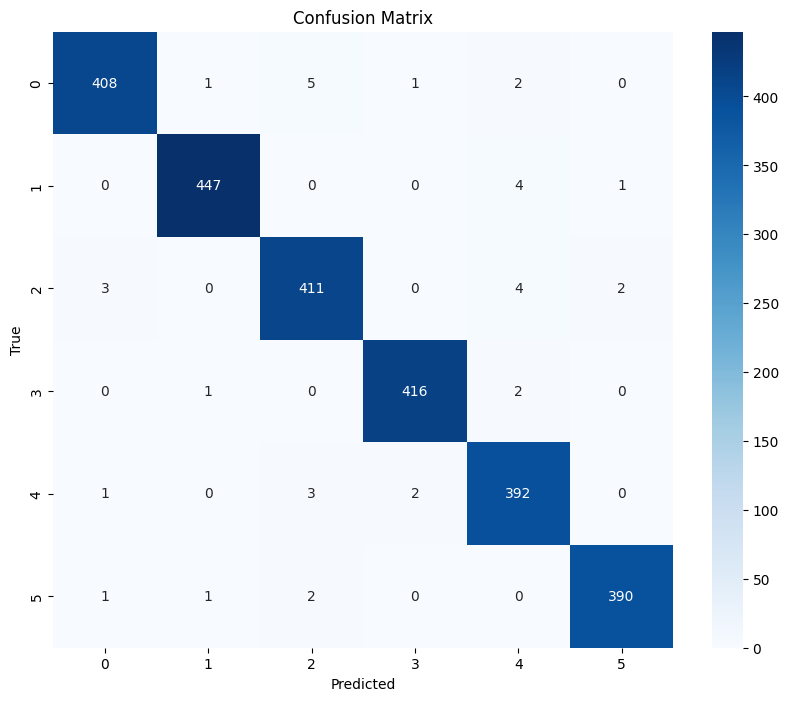

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [42]:
def analyze_predictions_and_errors(model, X_test, Y_test, tokenizer, data_for_lstms, class_names):
    """
    Analyze predictions, confidence distributions, and errors in detail
    """
    # Get predictions and true labels
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(Y_test, axis=1)

    # Get prediction confidences
    prediction_confidences = np.max(y_pred, axis=1)

    print("\n7. PREDICTION CONFIDENCE DISTRIBUTION")
    print("-"*50)

    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(prediction_confidences, bins=50, edgecolor='black')
    plt.title('Distribution of Prediction Confidences')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.axvline(x=np.mean(prediction_confidences), color='r', linestyle='--',
                label=f'Mean Confidence: {np.mean(prediction_confidences):.3f}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print confidence statistics
    print(f"\nConfidence Statistics:")
    print(f"Mean Confidence: {np.mean(prediction_confidences):.3f}")
    print(f"Median Confidence: {np.median(prediction_confidences):.3f}")
    print(f"Min Confidence: {np.min(prediction_confidences):.3f}")
    print(f"Max Confidence: {np.max(prediction_confidences):.3f}")

    print("\n8. ERROR ANALYSIS")
    print("-"*50)

    # Find misclassifications
    misclassified_indices = np.where(y_pred_classes != y_true)[0]
    num_misclassifications = len(misclassified_indices)

    print(f"Number of misclassifications: {num_misclassifications}")

    # Create a dictionary to store misclassification patterns
    misclassification_patterns = {}
    for idx in misclassified_indices:
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred_classes[idx]]
        pattern = (true_label, pred_label)
        misclassification_patterns[pattern] = misclassification_patterns.get(pattern, 0) + 1

    # Sort patterns by frequency
    sorted_patterns = sorted(misclassification_patterns.items(),
                           key=lambda x: x[1], reverse=True)

    print("\nMost common misclassifications:")
    for (true_label, pred_label), count in sorted_patterns[:5]:
        print(f"True: {true_label}, Predicted: {pred_label}, Count: {count}")

    print("\nMisclassified Examples Analysis:")
    print("-"*60)

    # Display some misclassified examples
    np.random.seed(42)
    sample_indices = np.random.choice(misclassified_indices,
                                    min(5, len(misclassified_indices)),
                                    replace=False)

    for idx in sample_indices:
        print(f"\nText: {data_for_lstms[idx][:200]}...")
        print(f"True Label: {class_names[y_true[idx]]}")
        print(f"Predicted Label: {class_names[y_pred_classes[idx]]}")
        print(f"Confidence: {np.max(y_pred[idx]):.3f}")
        print("-"*60)

    # Confidence analysis for correct vs incorrect predictions
    correct_confidences = prediction_confidences[y_pred_classes == y_true]
    incorrect_confidences = prediction_confidences[y_pred_classes != y_true]

    plt.figure(figsize=(10, 6))
    plt.hist(correct_confidences, bins=30, alpha=0.5, label='Correct Predictions',
             density=True, edgecolor='black')
    plt.hist(incorrect_confidences, bins=30, alpha=0.5, label='Incorrect Predictions',
             density=True, edgecolor='black')
    plt.title('Confidence Distribution: Correct vs Incorrect Predictions')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nConfidence Statistics for Correct vs Incorrect Predictions:")
    print(f"Mean Confidence (Correct): {np.mean(correct_confidences):.3f}")
    print(f"Mean Confidence (Incorrect): {np.mean(incorrect_confidences):.3f}")

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def generate_performance_report(model, X_test, Y_test, history, class_names):
    """
    Generate a comprehensive performance report for the LSTM model
    """
    print("="*50)
    print("LSTM MODEL PERFORMANCE REPORT")
    print("="*50)

    # 1. Overall Metrics
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(Y_test, axis=1)

    print("\n1. OVERALL METRICS")
    print("-"*20)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Accuracy: {accuracy:.4f}")

    # Calculate precision, recall, and f1-score for each class
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred_classes)

    # 2. Detailed Classification Report
    print("\n2. DETAILED CLASSIFICATION REPORT")
    print("-"*20)
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # 3. Confusion Matrix
    print("\n3. CONFUSION MATRIX")
    print("-"*20)
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 4. Training History Plots
    print("\n4. TRAINING HISTORY")
    print("-"*20)

    # Loss plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 5. Per-Class Metrics
    print("\n5. PER-CLASS METRICS")
    print("-"*20)

    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    print(metrics_df)

    # 6. Plot per-class metrics
    plt.figure(figsize=(12, 6))
    metrics_df.plot(x='Class', y=['Precision', 'Recall', 'F1-Score'], kind='bar')
    plt.title('Per-Class Performance Metrics')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 7. Model Summary
    print("\n6. MODEL SUMMARY")
    print("-"*20)
    model.summary()

    # 8. Add the new analysis
    analyze_predictions_and_errors(model, X_test, Y_test, tokenizer, data_for_lstms, class_names)

LSTM MODEL PERFORMANCE REPORT
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step

1. OVERALL METRICS
--------------------
Accuracy: 0.9856

2. DETAILED CLASSIFICATION REPORT
--------------------
                        precision    recall  f1-score   support

         art and music       0.99      0.98      0.98       417
                  food       0.99      0.99      0.99       452
               history       0.98      0.98      0.98       420
         manufacturing       0.99      0.99      0.99       419
science and technology       0.97      0.98      0.98       398
                travel       0.99      0.99      0.99       394

              accuracy                           0.99      2500
             macro avg       0.99      0.99      0.99      2500
          weighted avg       0.99      0.99      0.99      2500


3. CONFUSION MATRIX
--------------------


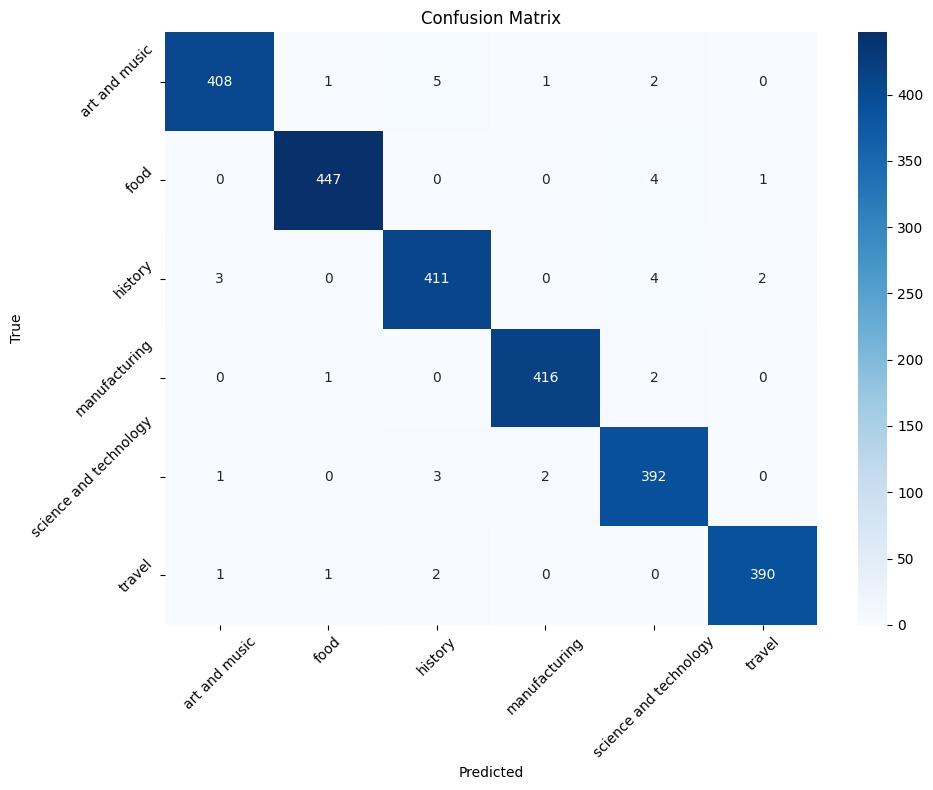


4. TRAINING HISTORY
--------------------


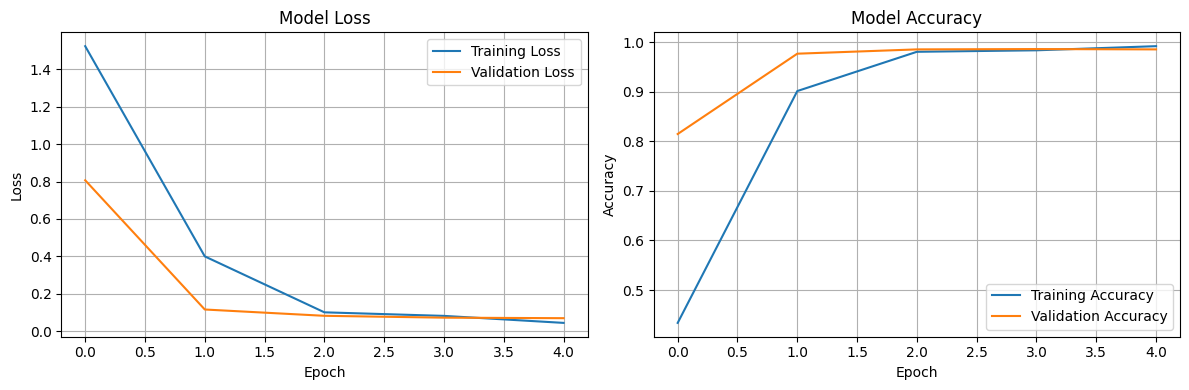


5. PER-CLASS METRICS
--------------------
                    Class  Precision    Recall  F1-Score  Support
0           art and music   0.987893  0.978417  0.983133      417
1                    food   0.993333  0.988938  0.991131      452
2                 history   0.976247  0.978571  0.977408      420
3           manufacturing   0.992840  0.992840  0.992840      419
4  science and technology   0.970297  0.984925  0.977556      398
5                  travel   0.992366  0.989848  0.991105      394


<Figure size 1200x600 with 0 Axes>

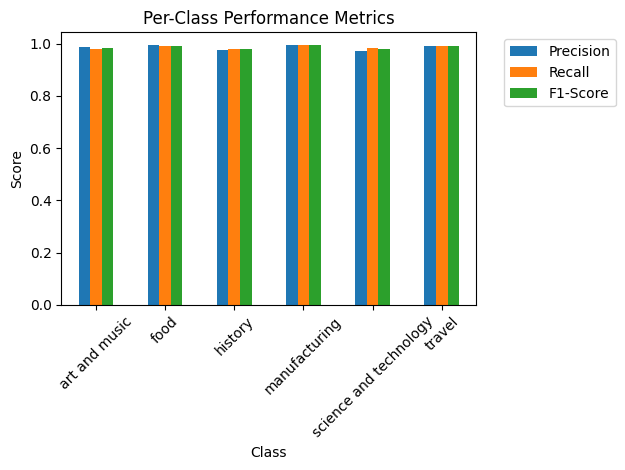


6. MODEL SUMMARY
--------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 56, 100)             │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 56, 100)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,243,020 (12.37 MB)

 Trainable params: 1,081,006 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,162,014 (8.25 MB)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

7. PREDICTION CONFIDENCE DISTRIBUTION
--------------------------------------------------


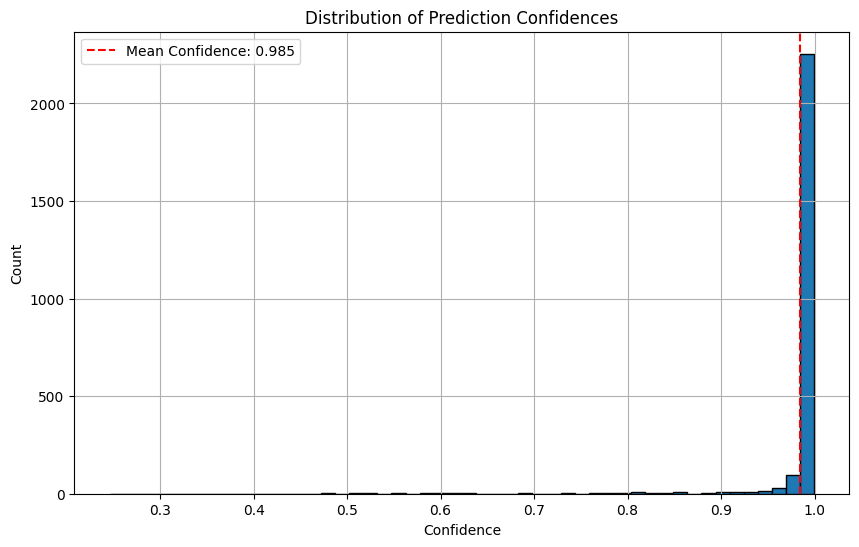


Confidence Statistics:
Mean Confidence: 0.985
Median Confidence: 0.998
Min Confidence: 0.246
Max Confidence: 1.000

8. ERROR ANALYSIS
--------------------------------------------------
Number of misclassifications: 36

Most common misclassifications:
True: art and music, Predicted: history, Count: 5
True: food, Predicted: science and technology, Count: 4
True: history, Predicted: science and technology, Count: 4
True: history, Predicted: art and music, Count: 3
True: science and technology, Predicted: history, Count: 3

Misclassified Examples Analysis:
------------------------------------------------------------

Text: oldest technologies scientists explain ancient inventions science explain...
True Label: science and technology
Predicted Label: history
Confidence: 0.998
------------------------------------------------------------

Text: jaguar earn drive smart wallet technology drivers able earn cryptocurrency make payments move innovative connect car service test jaguar land rover..

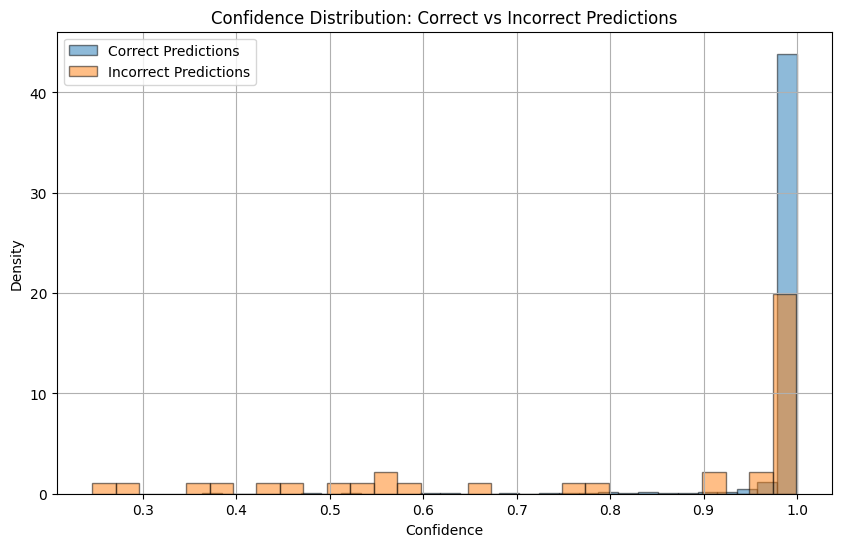


Confidence Statistics for Correct vs Incorrect Predictions:
Mean Confidence (Correct): 0.987
Mean Confidence (Incorrect): 0.799


In [46]:
# Call the function with your model and data
class_names = ['art and music', 'food', 'history', 'manufacturing',
              'science and technology', 'travel']  # Your class names

generate_performance_report(model, X_test, Y_test, history, class_names)

# **MODEL 2: Roberta**

In [49]:
# Check if GPU is available and set memory optimization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # Memory optimization
print(f"Using device: {device}")

Using device: cuda


In [50]:
n_classes = len(le.classes_)

# Split the data
X_train_model2, X_test_model2, y_train_model2, y_test_model2 = train_test_split(
    docs['combined_text'].values,
    docs['classes'].values,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [51]:
#  Modified Dataset class with shorter sequence length
class VideoAdvertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):  # Reduced from 512
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [52]:
# Simplified RoBERTa model
class RobertaClassifier(nn.Module):
    def __init__(self, n_classes):
        super(RobertaClassifier, self).__init__()
        # Load smaller RoBERTa model
        self.roberta = RobertaModel.from_pretrained('roberta-base')

        # Freeze most of the layers
        for param in self.roberta.parameters():
            param.requires_grad = False

        # Unfreeze only the last 2 layers
        for param in self.roberta.encoder.layer[-2:].parameters():
            param.requires_grad = True

        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return self.classifier(output)

In [53]:
# Optimized training function with mixed precision
def train_epoch(model, data_loader, optimizer, criterion, device, scaler):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Use mixed precision training
        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += len(labels)
        total_loss += loss.item()

    return total_loss / len(data_loader), correct_predictions.double() / total_predictions

In [54]:
# Initialize components with optimizations
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_dataset = VideoAdvertDataset(X_train_model2, y_train_model2, tokenizer)
test_dataset = VideoAdvertDataset(X_test_model2, y_test_model2, tokenizer)

# Larger batch size for faster training
train_loader = DataLoader(
    train_dataset,
    batch_size=32,  # Increased batch size
    shuffle=True,
    num_workers=4,  # Parallel data loading
    pin_memory=True  # Faster data transfer to GPU
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=4,
    pin_memory=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



In [55]:
# Initialize model and training components
model = RobertaClassifier(n_classes)
model = model.to(device)

# Use gradient accumulation
accumulation_steps = 2
effective_batch_size = 32 * accumulation_steps

optimizer = AdamW(model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()  # For mixed precision training

# Reduced number of epochs
n_epochs = 3

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

<ipython-input-55-ad682abfc598>:11: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



In [56]:
# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_predictions += len(labels)
            total_loss += loss.item()

    return total_loss / len(data_loader), correct_predictions.double() / total_predictions

In [57]:
# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []
learning_rates = []

# Training loop with metric tracking
from time import time
best_accuracy = 0
patience = 2
patience_counter = 0

for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    epoch_start = time()

    # Training phase
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, device, scaler
    )

    # Validation phase
    with torch.no_grad():
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.cpu().numpy())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.cpu().numpy())

    # Store epoch time
    epoch_times.append(time() - epoch_start)

    # Store learning rate
    learning_rates.append(optimizer.param_groups[0]['lr'])

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    print(f'Epoch Time: {epoch_times[-1]:.2f} seconds')

    # Early stopping
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_roberta_model.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1/3


  0%|          | 0/250 [00:00<?, ?it/s]<ipython-input-53-81e42504ecfa>:16: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

100%|██████████| 250/250 [00:40<00:00,  6.18it/s]


Train Loss: 0.6534, Train Acc: 0.7793
Val Loss: 0.1202, Val Acc: 0.9670
Epoch Time: 66.97 seconds
Epoch 2/3


100%|██████████| 250/250 [00:39<00:00,  6.34it/s]


Train Loss: 0.1233, Train Acc: 0.9680
Val Loss: 0.0954, Val Acc: 0.9720
Epoch Time: 65.18 seconds
Epoch 3/3


100%|██████████| 250/250 [00:40<00:00,  6.19it/s]


Train Loss: 0.0903, Train Acc: 0.9752
Val Loss: 0.0759, Val Acc: 0.9775
Epoch Time: 65.97 seconds


In [60]:
def analyze_roberta_errors(model, test_loader, device, class_names, tokenizer, X_test_model2):
    """
    Analyze prediction errors for the RoBERTa model
    """
    print("\n7. ERROR ANALYSIS")
    print("-"*50)

    model.eval()
    predictions = []
    true_labels = []
    confidence_scores = []
    all_outputs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidence, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidence_scores.extend(confidence.cpu().numpy())
            all_outputs.extend(probs.cpu().numpy())

    # Find misclassifications
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    misclassified_indices = np.where(predictions != true_labels)[0]
    num_misclassifications = len(misclassified_indices)

    print(f"Number of misclassifications: {num_misclassifications}")

    # Create a dictionary to store misclassification patterns
    misclassification_patterns = {}
    for idx in misclassified_indices:
        true_label = class_names[true_labels[idx]]
        pred_label = class_names[predictions[idx]]
        pattern = (true_label, pred_label)
        misclassification_patterns[pattern] = misclassification_patterns.get(pattern, 0) + 1

    # Sort patterns by frequency
    sorted_patterns = sorted(misclassification_patterns.items(),
                           key=lambda x: x[1], reverse=True)

    print("\nMost common misclassifications:")
    for (true_label, pred_label), count in sorted_patterns[:5]:
        print(f"True: {true_label}, Predicted: {pred_label}, Count: {count}")

    print("\nMisclassified Examples Analysis:")
    print("-"*60)

    # Display some misclassified examples
    np.random.seed(42)
    sample_indices = np.random.choice(misclassified_indices,
                                    min(5, len(misclassified_indices)),
                                    replace=False)

    for idx in sample_indices:
        batch_idx = idx // test_loader.batch_size
        within_batch_idx = idx % test_loader.batch_size

        print(f"\nText: {X_test_model2[idx][:200]}...")
        print(f"True Label: {class_names[true_labels[idx]]}")
        print(f"Predicted Label: {class_names[predictions[idx]]}")
        print(f"Confidence: {confidence_scores[idx]:.3f}")
        print("-"*60)

    # Confidence analysis for correct vs incorrect predictions
    correct_mask = predictions == true_labels
    correct_confidences = np.array(confidence_scores)[correct_mask]
    incorrect_confidences = np.array(confidence_scores)[~correct_mask]

    plt.figure(figsize=(10, 6))
    plt.hist(correct_confidences, bins=30, alpha=0.5, label='Correct Predictions',
             density=True, edgecolor='black')
    plt.hist(incorrect_confidences, bins=30, alpha=0.5, label='Incorrect Predictions',
             density=True, edgecolor='black')
    plt.title('Confidence Distribution: Correct vs Incorrect Predictions')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nConfidence Statistics for Correct vs Incorrect Predictions:")
    print(f"Mean Confidence (Correct): {np.mean(correct_confidences):.3f}")
    print(f"Mean Confidence (Incorrect): {np.mean(incorrect_confidences):.3f}")

In [63]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def generate_roberta_performance_report(model, test_loader, device, class_names,
                                      train_losses, train_accuracies,
                                      val_losses, val_accuracies,
                                      tokenizer, X_test_model2):
    """
    Generate a comprehensive performance report for the RoBERTa model
    """
    print("="*50)
    print("RoBERTa MODEL PERFORMANCE REPORT")
    print("="*50)

    # Get predictions
    model.eval()
    predictions = []
    true_labels = []
    confidence_scores = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            # Get confidence scores using softmax
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidence, _ = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidence_scores.extend(confidence.cpu().numpy())

    # 1. Overall Metrics
    print("\n1. OVERALL METRICS")
    print("-"*20)
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy:.4f}")

    # 2. Detailed Classification Report
    print("\n2. DETAILED CLASSIFICATION REPORT")
    print("-"*20)
    print(classification_report(true_labels, predictions, target_names=class_names))

    # 3. Confusion Matrix
    print("\n3. CONFUSION MATRIX")
    print("-"*20)
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 4. Training History
    print("\n4. TRAINING HISTORY")
    print("-"*20)

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 5. Confidence Analysis
    print("\n5. CONFIDENCE ANALYSIS")
    print("-"*20)

    correct = np.array(predictions) == np.array(true_labels)
    correct_confidences = np.array(confidence_scores)[correct]
    incorrect_confidences = np.array(confidence_scores)[~correct]

    plt.figure(figsize=(10, 6))
    plt.hist(correct_confidences, bins=30, alpha=0.5, label='Correct Predictions',
             density=True, color='green')
    plt.hist(incorrect_confidences, bins=30, alpha=0.5, label='Incorrect Predictions',
             density=True, color='red')
    plt.title('Confidence Distribution: Correct vs Incorrect Predictions')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nConfidence Statistics:")
    print(f"Mean Confidence (Correct): {np.mean(correct_confidences):.3f}")
    print(f"Mean Confidence (Incorrect): {np.mean(incorrect_confidences):.3f}")
    print(f"Overall Mean Confidence: {np.mean(confidence_scores):.3f}")

    # 6. Per-Class Performance
    precision, recall, f1, support = precision_recall_fscore_support(true_labels, predictions)

    print("\n6. PER-CLASS PERFORMANCE")
    print("-"*20)

    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    print(metrics_df)

    # Plot per-class metrics
    plt.figure(figsize=(12, 6))
    metrics_df.plot(x='Class', y=['Precision', 'Recall', 'F1-Score'], kind='bar')
    plt.title('Per-Class Performance Metrics')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Add error analysis at the end
    analyze_roberta_errors(model, test_loader, device, class_names, tokenizer, X_test_model2)


RoBERTa MODEL PERFORMANCE REPORT


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.




1. OVERALL METRICS
--------------------
Accuracy: 0.9775

2. DETAILED CLASSIFICATION REPORT
--------------------
                        precision    recall  f1-score   support

         art and music       0.98      0.98      0.98       335
                  food       0.99      0.98      0.99       339
               history       0.96      0.96      0.96       326
         manufacturing       0.97      1.00      0.99       335
science and technology       0.98      0.96      0.97       331
                travel       0.98      0.99      0.98       334

              accuracy                           0.98      2000
             macro avg       0.98      0.98      0.98      2000
          weighted avg       0.98      0.98      0.98      2000


3. CONFUSION MATRIX
--------------------


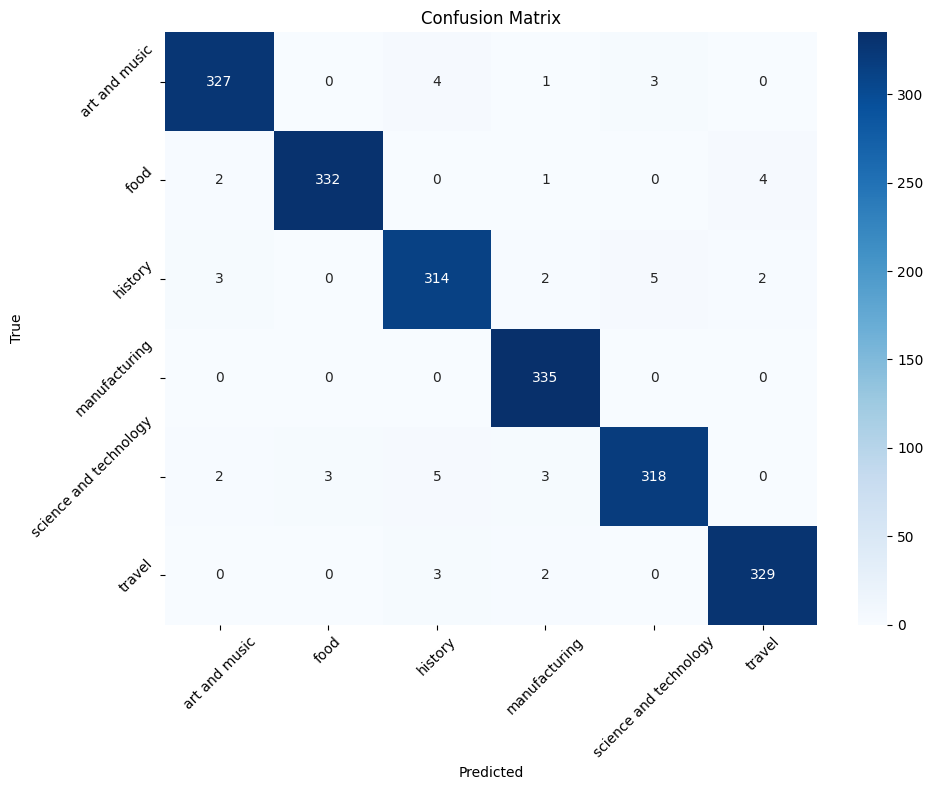


4. TRAINING HISTORY
--------------------


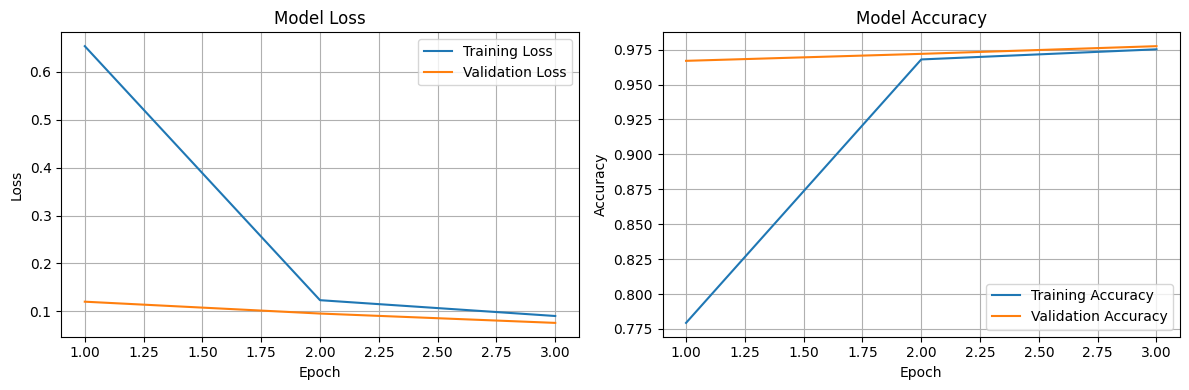


5. CONFIDENCE ANALYSIS
--------------------


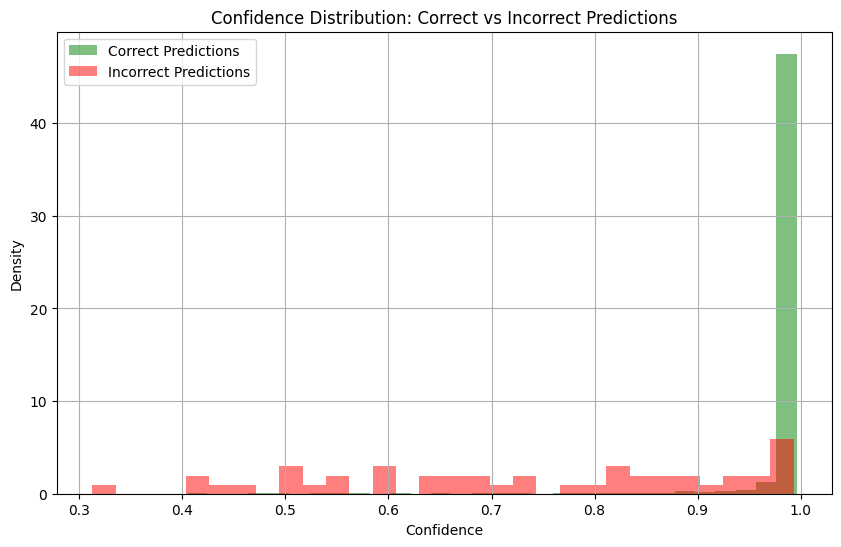


Confidence Statistics:
Mean Confidence (Correct): 0.986
Mean Confidence (Incorrect): 0.734
Overall Mean Confidence: 0.980

6. PER-CLASS PERFORMANCE
--------------------
                    Class  Precision    Recall  F1-Score  Support
0           art and music   0.979042  0.976119  0.977578      335
1                    food   0.991045  0.979351  0.985163      339
2                 history   0.963190  0.963190  0.963190      326
3           manufacturing   0.973837  1.000000  0.986745      335
4  science and technology   0.975460  0.960725  0.968037      331
5                  travel   0.982090  0.985030  0.983558      334


<Figure size 1200x600 with 0 Axes>

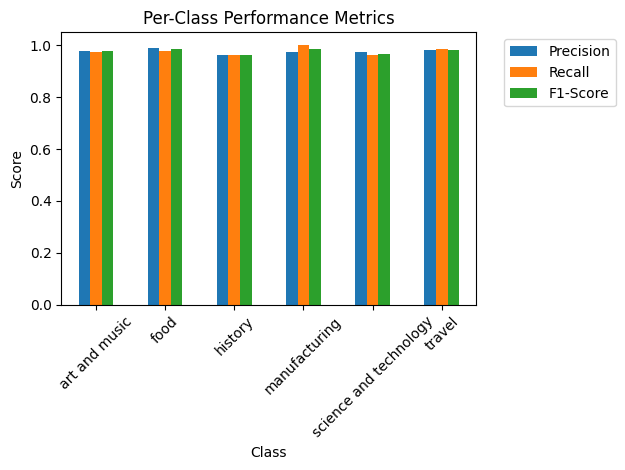


7. ERROR ANALYSIS
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Number of misclassifications: 45

Most common misclassifications:
True: science and technology, Predicted: history, Count: 5
True: history, Predicted: science and technology, Count: 5
True: food, Predicted: travel, Count: 4
True: art and music, Predicted: history, Count: 4
True: art and music, Predicted: science and technology, Count: 3

Misclassified Examples Analysis:
------------------------------------------------------------

Text: primitive technology eat delicious smart boy cook pig head day wantto videos primitive technology eat delicious smart boy cook pig head like video please ckick like share...
True Label: science and technology
Predicted Label: food
Confidence: 0.658
------------------------------------------------------------

Text: go college may first open list people school link twitter nycjani insta janidumz music picture girls wallow instrumental people...
True Label: history
Predicted Label: science and technology
Confidence: 0.605
---------------------------------

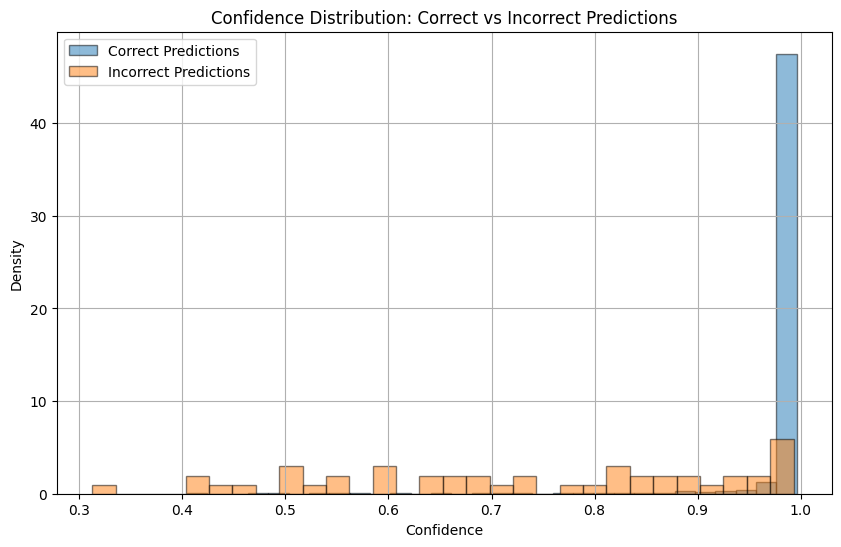


Confidence Statistics for Correct vs Incorrect Predictions:
Mean Confidence (Correct): 0.986
Mean Confidence (Incorrect): 0.734


In [64]:
# # Call the function
# generate_roberta_performance_report(
#     model=model,
#     test_loader=test_loader,
#     device=device,
#     class_names=class_names,
#     train_losses=train_losses,
#     train_accuracies=train_accuracies,
#     val_losses=val_losses,
#     val_accuracies=val_accuracies
# )

# Call the updated function
generate_roberta_performance_report(
    model=model,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    val_losses=val_losses,
    val_accuracies=val_accuracies,
    tokenizer=tokenizer,
    X_test_model2=X_test_model2
)